In [107]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [108]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [109]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) #bias = False?
        self.relu1 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.multiplier = np.sqrt(hidden_size)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.output_layer(x)
        x = x*self.multiplier
        return x

# Set random seed for reproducibility
torch.manual_seed(42)

# Define synthetic input data
input_size = 20
synthetic_input = torch.rand(input_size)

# Instantiate the neural network
hidden_size = 20
output_size = 1
model_1 = FeedforwardNN(input_size, hidden_size, output_size)

# Forward pass
output = model_1(synthetic_input)

# To GPU
model_1 = model_1.to(device)

# Print the architecture and output shape
print(model_1)
print("Output shape:", output.shape)

FeedforwardNN(
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (relu1): ReLU()
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)
Output shape: torch.Size([1])


In [110]:
initial_weights = model_1.state_dict()

In [111]:
p = 0
for name, param in model_1.named_parameters():
    if 'weight' in name:
        x,y = param.size()
        p += x*y
        print(f'Layer: {name}, Size: {param.size()}')
print('Number of parameters:',p)

Layer: layer1.weight, Size: torch.Size([20, 20])
Layer: output_layer.weight, Size: torch.Size([1, 20])
Number of parameters: 420


In [112]:
def random_ball(num_points,dimension,radius = 1):
    output = []
    for n in range(num_points):
        x = np.random.randn(20)
        x /= np.linalg.norm(x, ord=2)
        x = torch.tensor(x,dtype = torch.float32)
        if num_points == 1:
            return x
        output.append(x)
    return torch.stack(output)

In [113]:
# Careful: Adding too much noise breaks it as the noise takes over. But noise doesn't break if the reward is high

a = random_ball(1,20,1).reshape(-1).to(device)
def reward_function_quadratic(context):
    return 10*(torch.dot(context,a)**2).item() + (0.1*torch.randn(1)).item()
#     return 10*(torch.dot(context,a)**2).item()
reward_function_quadratic(random_ball(1,20).to(device))

2.106140088289976

In [114]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predicted, target,flattened_initial_weights,flattened_current_weights):
        loss = (0.5*torch.sum((predicted - target)**2))/target.shape[0]
        m = 20
        lamb = 1
        norm = 0.5*m*lamb*(torch.norm(flattened_initial_weights - flattened_current_weights, p=2)**2)
        return loss + norm

In [115]:
def train_nn(input_data,best_rewards,initial_weights,step_size, J = 20):
    model_inside = FeedforwardNN(input_size, hidden_size, output_size).to(device)
    model_inside.load_state_dict(initial_weights)

    loss_function = CustomLoss()

    optimizer = optim.SGD(model_inside.parameters(),lr = step_size) # Need to fix to GD?
    size = len(input_data)
    rewards = torch.tensor(best_rewards).reshape(-1,1)
    dataset = TensorDataset(input_data,rewards)
    
    batch_size = 50
    shuffle = True  # Set to True if you want to shuffle the data
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)    

    flattened_initial_weights = torch.cat([p.flatten() for p in initial_weights.values()])
    
    for j in range(J):
        for inputs,targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model_inside(inputs)
            current_weights = model_inside.state_dict()
            flattened_current_weights = torch.cat([p.flatten() for p in current_weights.values()])
            loss = loss_function(output, targets,flattened_initial_weights,flattened_current_weights)
            loss.backward()
            optimizer.step()
        
    print('--------------------------------------')

    model_weights = model_inside.state_dict()
    return model_weights

In [116]:
def get_regret(data,best_action,reward_function):
    best_reward = -np.inf
    rewards = []
    for idx,t in enumerate(data):
        reward = reward_function(t)
        if reward > best_reward:
            best_reward = reward
            best_idx = idx
            
        rewards.append(reward)
            
    chosen_reward = rewards[best_action]
    regret = best_reward - chosen_reward
    return regret

In [117]:
def NeuralUCB(model,reward_function,initial_weights, T, lamb = 1, step_size = 0.001):
    Z = lamb * torch.eye(p).to(device)
    K = 4
    dim = 20 # feature vector dimension (context)
    m = 20 # Neural Network width
    gamma = 1
    best_contexts = []
    best_rewards = []
    regrets = []
    for t in range(T):
        synthetic_input = random_ball(K,dim).to(device) # "K" arms x "dim" feature size
        all_grad = []
        ucbs = []
        for k in range(K):
            output = model(synthetic_input[k])
            model.zero_grad()
            output.backward(torch.ones_like(output),retain_graph = True)
            g = []
            for name, param in model.named_parameters():
                if 'weight' in name:
                    tmp = param.grad.flatten()
                    g.append(tmp)
            g = torch.cat(g,dim = 0).reshape(-1,1).to(device)
    
    
            Z_inv = torch.inverse(Z)
            
            
            all_grad.append(g)
            exploration_reward = gamma*torch.sqrt((g.T@Z_inv@g)/m) 
            ucb_a = output + exploration_reward
            ucbs.append(ucb_a.item())
            
            
        ucbs = torch.tensor(ucbs)
        best_action = torch.argmax(ucbs).item()
        best_context = synthetic_input[best_action]
        best_g = all_grad[best_action]
        best_reward = reward_function(best_context)
        Z = Z + (best_g@best_g.T/m)
        
        best_contexts.append(best_context)
        
        
        best_rewards.append(best_reward)
        
        
        
        if (t+1)%50 == 0:
            ### Train Neural Network
            new_weights = train_nn(torch.stack(best_contexts),
                                   torch.tensor(best_rewards),
                                   initial_weights,
                                   step_size = step_size,
                                   J = t+1)
            model.load_state_dict(new_weights)
            print(f'Training NN step {t+1}')
            print('Cumulative Regret: ' , np.sum(regrets))

        regret = get_regret(synthetic_input,best_action,reward_function)
        regrets.append(regret)
        
        # Update gamma: To be updated        
        
        
        
    return model,regrets

### Quadratic function

In [118]:
model_1,regrets_1 = NeuralUCB(model_1,reward_function_quadratic,initial_weights,1000)

C:\Users\chana\AppData\Local\Temp\ipykernel_7416\4264651518.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(best_rewards).reshape(-1,1)


--------------------------------------
Training NN step 50
Cumulative Regret:  48.86995837362156
--------------------------------------
Training NN step 100
Cumulative Regret:  89.22926634365831
--------------------------------------
Training NN step 150
Cumulative Regret:  117.10859169785567
--------------------------------------
Training NN step 200
Cumulative Regret:  150.51698329216038
--------------------------------------
Training NN step 250
Cumulative Regret:  181.54312564014594
--------------------------------------
Training NN step 300
Cumulative Regret:  202.38918039679425
--------------------------------------
Training NN step 350
Cumulative Regret:  231.18147352296006
--------------------------------------
Training NN step 400
Cumulative Regret:  252.82142714609296
--------------------------------------
Training NN step 450
Cumulative Regret:  278.2754647368093
--------------------------------------
Training NN step 500
Cumulative Regret:  297.63500056360687
--------------

In [119]:
def plot_cumulative(data):
    cumulative_sum = np.cumsum(data)
    plt.plot(cumulative_sum)
    plt.xlabel('Index')
    plt.ylabel('Cumulative Sum')
    plt.title('Cumulative Sum Plot')
    plt.grid(True)
    plt.show()

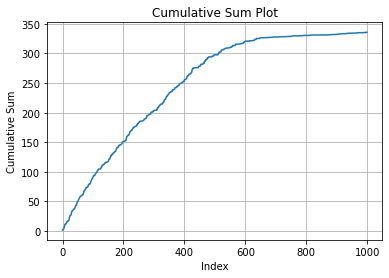

In [120]:
plot_cumulative(regrets_1)

### Result Testing: Quadratic

In [121]:
test = random_ball(4,20).to(device)
print(test)

tensor([[ 0.0209, -0.1756, -0.1094, -0.0564,  0.0969,  0.2426,  0.1705,  0.2289,
         -0.2481, -0.3333,  0.1450,  0.0541, -0.2715, -0.0634, -0.1015, -0.6213,
         -0.1756,  0.0489,  0.3105, -0.0601],
        [ 0.0389,  0.1717,  0.1798, -0.0494,  0.1315,  0.0128, -0.0552, -0.1827,
         -0.4224,  0.2126, -0.1924,  0.0604, -0.3235, -0.2800,  0.1018,  0.3890,
         -0.0061,  0.2390,  0.3970,  0.2379],
        [-0.1571, -0.1046, -0.2892, -0.0416,  0.3006,  0.1306, -0.2126, -0.2844,
         -0.0904, -0.0273,  0.1253, -0.0636,  0.2268, -0.4737,  0.0675, -0.1214,
          0.0993, -0.0868,  0.3934,  0.3867],
        [-0.1772,  0.2239, -0.0293, -0.3612, -0.1474, -0.3090, -0.2483,  0.1533,
         -0.2984, -0.3871,  0.1666,  0.2122,  0.1064,  0.2964, -0.2557, -0.1222,
          0.0569,  0.2671, -0.0637, -0.1225]], device='cuda:0')


In [122]:
best_idx = 0
best_reward = 0
for idx,t in enumerate(test):
    reward = reward_function_quadratic(t)
    if reward>best_reward:
        best_reward = reward
        best_idx = idx
    print(f'idx_{idx} reward: ',reward)

idx_0 reward:  1.720720261335373
idx_1 reward:  0.227510467171669
idx_2 reward:  0.21712196618318558
idx_3 reward:  -0.02728229737840593


In [123]:
model_1(test)

tensor([[ 1.6829],
        [ 0.3744],
        [ 0.4980],
        [-0.1370]], device='cuda:0', grad_fn=<MulBackward0>)

## cos function

In [124]:
model_2 = FeedforwardNN(input_size, hidden_size, output_size)
model_2 = model_2.to(device)
initial_weights = model_2.state_dict()

In [125]:
a = random_ball(1,20,1).reshape(-1).to(device)
def reward_function_cos(context):
#     return np.cos(3*(torch.dot(context,a)).item()) + (0.1*torch.randn(1)).item()
    return np.cos(3*(torch.dot(context,a)).item())
reward_function_cos(random_ball(1,20).to(device))

0.9958812881588834

In [ ]:
model_2,regrets_2 = NeuralUCB(model_2,reward_function_cos,initial_weights,1000)

C:\Users\chana\AppData\Local\Temp\ipykernel_7416\4264651518.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(best_rewards).reshape(-1,1)


--------------------------------------
Training NN step 50
Cumulative Regret:  5.592399726139931
--------------------------------------
Training NN step 100
Cumulative Regret:  13.9184480412633
--------------------------------------
Training NN step 150
Cumulative Regret:  23.926334362213957
--------------------------------------
Training NN step 200
Cumulative Regret:  32.790714992441856
--------------------------------------
Training NN step 250
Cumulative Regret:  41.90028328235129


In [ ]:
plot_cumulative(regrets_2)

### Result Testing: Cos

In [ ]:
test = random_ball(4,20).to(device)

In [ ]:
best_idx = 0
best_reward = 0
for idx,t in enumerate(test):
    reward = reward_function_cos(t)
    if reward>best_reward:
        best_reward = reward
        best_idx = idx
    print(f'idx_{idx} reward: ',reward)

In [ ]:
model_2(test)